In [2]:
import numpy
from matplotlib import pyplot
from scipy.constants import c
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [4]:
def window_function(u, u_0, sigma):
    return numpy.exp(-(u-u_0)**2.*sigma)

In [5]:
def averaged_window_function(u,u_offsets,sigma):
    offset_windows = numpy.array([window_function(u, u_i, sigma) for u_i in u_offsets])
    print(offset_windows.shape)
    
    averaged_window = numpy.mean(offset_windows, axis=0)
    print(averaged_window.shape)
    return averaged_window

In [6]:
def summed_window_function(u,u_offsets,sigma):
    offset_windows = numpy.array([window_function(u, u_i, sigma) for u_i in u_offsets])
    print(offset_windows.shape)
    
    summed_window = numpy.sum(offset_windows, axis=0)
    return summed_window

(4, 100)
(100,)
(4, 100)


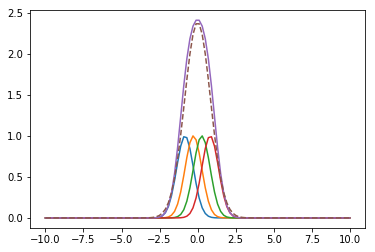

In [7]:
wavelength = 2.
x_coordinates = numpy.array([-1.5,-0.5,0.5,1.5])*1.1
u_offsets = x_coordinates/wavelength
width = (x_coordinates.max() - x_coordinates.min())/wavelength


u_coordinates = numpy.linspace(-10,10,100)

averaged_window = averaged_window_function(u_coordinates, u_offsets, width )
summed_window = summed_window_function(u_coordinates, u_offsets, width )



for offset in u_offsets:
    single = window_function(u_coordinates, offset, width)
    pyplot.plot(u_coordinates,single)

approximation = window_function(u_coordinates, 0, width*0.42)/0.42

#pyplot.plot(u_coordinates, averaged_window)
pyplot.plot(u_coordinates, summed_window)
pyplot.plot(u_coordinates, approximation, linestyle='--')

In [8]:
def beam_width(frequency, diameter= 4, epsilon = 1):
    
    sigma =  epsilon*c/(frequency*diameter)
    width = numpy.sin(0.5*sigma)
    return width

## Can I Object Orientify my SCAR code?

In [9]:
class PointSourceSky:
    
    def __init__(self):
        self.flux_0 = None
        self.frequency_0 = None
        self.l_coordinate = None
        self.m_coordinate = None
        self.spectral_index = 0.8
        
        
    def add_source(self, flux, frequency_0 = 150e6, l_coordinate = 0, m_coordinate =0 , spectral_index=0.8):
        assert isinstance(flux, numpy.ndarray), "Please input a numpy array for flux"
        assert isinstance(frequency_0, numpy.ndarray), "Please input a numpy array for frequency"
        assert isinstance(l_coordinate, numpy.ndarray), "Please input a numpy array l coordinate"
        assert isinstance(m_coordinate, numpy.ndarray), "Please input a numpy array m coordinate"
        assert isinstance(spectral_index, numpy.ndarray), "Please input a numpy array spectral index"

        if self.flux_0 == None:
            self.flux_0 = flux
            self.frequency_0 = frequency_0
            self.l_coordinate = l_coordinate
            self.m_coordinate = m_coordinate
            self.spectral_index = spectral_index
        else:
            self.flux_0.append(flux)
            self.frequency_0.append(frequency_0)
            self.l_coordinate.append(l_coordinate)
            self.m_coordinate.append(m_coordinate)
            self.spectral_index.append(spectral_index)
        return
            
    

## The Analytical Covariance Expression

In [10]:
def visibility_model(x_spacing, y_spacing, nu, sources):
    wavelength =  c/nu
    u = x_spacing/wavelength
    v = y_spacing/wavelength
    
    sigma = beam_width(nu)
    visibilities = numpy.zeros(nu.shape, dtype=complex)
    for i in range(len(sources.flux_0)):
        source_l = sources.l_coordinate[i]
        source_m = sources.m_coordinate[i]
        
        beam_response = numpy.exp(-(source_l**2. +  source_m**2.)/sigma)
        fourier_kernel= numpy.exp(-2*numpy.pi*1j*(source_l*u + source_m*v))
        visibilities += sources.flux_0[i]*beam_response**2.*fourier_kernel
    
    return visibilities

def visibility_perturbation(u,v, frequency1, sources):
    perturbation = numpy.zeros(frequency1.shape, dtype=complex)
    nu_low = numpy.min(frequency1)
    for i in range(len(sources.flux_0)):
        source_l = sources.l_coordinate[i]
        source_m = sources.m_coordinate[i]
        
        beam_response = numpy.exp(-(sources.source_l**2. +  sources.m_coordinate[i]**2.)/beamwidth(frequency1))
        
        fourier_kernel= numpy.exp(-2*numpy.pi*1j*(source_l*u + source_m*v)*frequency1/nu_low)
        
        visibility = sources.flux_0[i]*(frequency1/nu_low)**-0.8*beam_response**2.*fourier_kernel
        perturbation_phase = numpy.exp(2*numpy.pi*1j*sources.l_coordinate)
        perturbation += visibility
    

def beam_covariance(dx ,dy, nu1, nu2 , sources):
    
    model_visibility_1 = visibility_model(dx,dy, nu1, sources)
    model_visibility_2 = visibility_model(dx,dy, nu2, sources)
    
    pert_visibility_1 = dV(dx, dy, nu1, sources)
    pert_visibility_2 = dV(dx, dy, nu2, sources)

    C = model_visibility_1*numpy.conj(pert_visibility_2) + numpy.conj(model_visibility_2)*pert_visibility_1

    return C


def dV(x_spacing, y_spacing, nu, sources):
    D = 4
    dx= 1.1
    sigma = beam_width(nu)

    wavelength =  c/nu
    u = x_spacing/wavelength
    v = y_spacing/wavelength
    
    visibility_perturbation = numpy.zeros_like(nu, dtype = complex)

    for source_index in range(len(sources.flux_0)):
        source_l = sources.l_coordinate[source_index]
        source_m = sources.m_coordinate[source_index]
        source_S = sources.flux_0[source_index]
        
        beam_attenuation = numpy.exp(-(source_l**2. + source_m**2.)/(2*sigma**2.))
        
        source_visibility= source_S*numpy.exp(-2.*numpy.pi*1j*(u*source_l + v*source_m))
        
        model_visibility = source_visibility*beam_attenuation**2.
        
        dipole_factor = numpy.exp(-2.*numpy.pi*1j*(source_l + source_m)*D/(2*wavelength))
        
        dipole_fraction= (numpy.exp(2*numpy.pi*1j*source_l*D/wavelength) - 1)/\
            (numpy.exp(2*numpy.pi*1j*source_l*dx/wavelength) - 1)*\
            (numpy.exp(2*numpy.pi*1j*source_m*D/wavelength) - 1)/\
            (numpy.exp(2*numpy.pi*1j*source_m*dx/wavelength) - 1)
        
        visibility_perturbation += 1/16**2*model_visibility*dipole_factor*dipole_fraction
    
    return visibility_perturbation  

In [11]:
sky_param = ['point', 200, 0.5, 0.01]


In [88]:
flux = numpy.array([sky_param[1]])
frequency_0 = numpy.array([150e6])
source_l = numpy.array([sky_param[2]])
source_m = numpy.array([sky_param[3]])
spectral_index = numpy.array([0.8])


sky_model = PointSourceSky()
sky_model.add_source(flux, frequency_0, source_l, source_m, spectral_index)

In [89]:
frequency_range = numpy.linspace(140, 160, 10)*1e6


In [90]:
dx = 20
dy = 10

ff1, ff2 = numpy.meshgrid(frequency_range, frequency_range)

analytic_covariance = beam_covariance(dx, dy, ff1, ff2, sky_model)

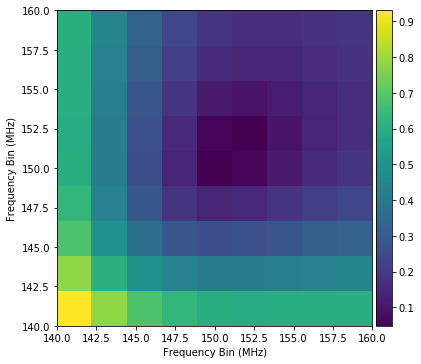

In [91]:
figure = pyplot.figure(figsize = (6,6))
covariance_plot = figure.add_subplot(111)
cov_h = covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(analytic_covariance))
covariance_plot.set_xlabel('Frequency Bin (MHz)')
covariance_plot.set_ylabel('Frequency Bin (MHz)')
covariance_plot.set_title("Fully Analytic")
colorbar(cov_h)

covariance_plot.set_aspect('equal')

## The Numerical Covariance Calculation

In [12]:
import os
import numpy
import powerbox
import time
from scipy import interpolate

from matplotlib import pyplot
from matplotlib.widgets import Slider
from scipy.constants import c as light_speed

import sys
sys.path.append('../../../redundant_calibration/code/SCAR')
from RadioTelescope import antenna_gain_creator
from RadioTelescope import baseline_converter
from RadioTelescope import xyz_position_creator
from SkyModel import flux_list_to_sky_image
from SkyModel import flux_distribution
from quick_simulation_visibility_covariance import lm_to_theta_phi
from quick_simulation_visibility_covariance import mwa_tile_beam
from quick_simulation_visibility_covariance import interactive_frequency_plotter

In [22]:
def visibility_beam_covariance(xyz_positions, frequency_range, sky_param, sky_seed = 0, load = True, verbose = True):
    baseline_index = 0
    gain_table = antenna_gain_creator(xyz_positions, frequency_range)
    baseline_table = baseline_converter(xyz_positions, gain_table, frequency_range, verbose = verbose)

    if sky_param[0] == 'random':
        all_flux, all_l, all_m = flux_distribution(['random', sky_seed])
    elif sky_param[0] == 'point':
        all_flux, all_l, all_m = flux_distribution(['single', sky_param[1],
                                                    sky_param[2], sky_param[3]])
    point_source_list = numpy.stack((all_flux, all_l, all_m), axis=1)
    
    if verbose:
        print("Creating the sky\n")
    sky_cube, l_coordinates, m_coordinates = flux_list_to_sky_image(point_source_list, baseline_table)
    ll, mm, ff = numpy.meshgrid(l_coordinates, m_coordinates, frequency_range)
    tt, pp, = lm_to_theta_phi(ll, mm)

    if not load:
        if verbose:
            print("Creating the idealised MWA beam\n")
        ideal_beam = mwa_tile_beam(tt, pp, frequency=ff)
        if not os.path.exists("beam_maps"):
            print("")
            print("Creating beam map folder locally!")
            os.makedirs("beam_maps")
        numpy.save(f"beam_maps/ideal_beam_map.npy", ideal_beam)
    if load:
        if verbose:
            print("Loading the idealised MWA beam\n")
        ideal_beam = numpy.load(f"beam_maps/ideal_beam_map.npy")

    baseline_selection = numpy.array([baseline_table[baseline_index]])
    visibility_realisations = numpy.zeros((frequency_range.shape[0], 16), dtype=complex)
    
    if verbose:
        print("Iterating over 16 realisations of a perturbed MWA beam")
    for faulty_dipole in range(16):
        dipole_weights = numpy.zeros(16) + 1
        dipole_weights[faulty_dipole] = 0
        if load:
            print(f"Loading perturbed tile beam for dipole {faulty_dipole}")
            perturbed_beam = numpy.load(f"beam_maps/perturbed_dipole_{faulty_dipole}_map.npy")
        elif not load:
            #print(f"Generating perturbed tile beam for dipole {faulty_dipole}")
            perturbed_beam = mwa_tile_beam(tt, pp, weights=dipole_weights, frequency=ff)
            if not os.path.exists("beam_maps"):
                print("")
                print("Creating beam map folder locally!")
                os.makedirs("beam_maps")
            numpy.save(f"beam_maps/perturbed_dipole_{faulty_dipole}_map.npy", perturbed_beam)

        #print(f"Extracting Visibilities")
        for frequency_index in range(len(frequency_range)):
            visibility_realisations[frequency_index, faulty_dipole] = visibility_extractor(
                baseline_selection[:, :, frequency_index], sky_cube[:, :, frequency_index],
                ideal_beam[:, :, frequency_index], perturbed_beam[:, :, frequency_index])

    if verbose:
        print("Calculating the covariance matrix for a single baseline over the frequency range")

    visibility_covariance = numpy.cov(visibility_realisations)

    return visibility_realisations



def visibility_extractor(baseline_table, sky_cube, antenna1_response, antenna2_response):
    apparent_sky = sky_cube * antenna1_response * numpy.conj(antenna2_response)
    padding_factor = 3

    padded_sky = numpy.pad(apparent_sky, padding_factor * len(apparent_sky), mode="constant")
    shifted_image = numpy.fft.ifftshift(padded_sky, axes=(0, 1))
    visibility_grid, uv_coordinates = powerbox.dft.fft(shifted_image, L=2 * (2 * padding_factor + 1), axes=(0, 1))
    measured_visibilities = uv_list_to_baseline_measurements(baseline_table, visibility_grid, uv_coordinates)

    return measured_visibilities


def uv_list_to_baseline_measurements(baseline_table, visibility_grid, uv_grid):

    u_bin_centers = uv_grid[0]
    v_bin_centers = uv_grid[1]

    # now we have the bin edges we can start binning our baseline table
    # Create an empty array to store our baseline measurements in
    visibility_data = visibility_grid

    real_component = interpolate.RegularGridInterpolator((u_bin_centers, v_bin_centers), numpy.real(visibility_data))
    imag_component = interpolate.RegularGridInterpolator((u_bin_centers, v_bin_centers), numpy.imag(visibility_data))
    visibilities = real_component(baseline_table[:, 2:4]) + \
                   1j * imag_component(baseline_table[:, 2:4])

    return visibilities

In [94]:
# create array
noise_param = [False, 20e3, 40e3, 120]
beam_param = ['gaussian', 0.25, 0.25]
# telescope_param = ["hex", 14., 0, 0]
telescope_param = ["linear", 10, 5, 0]
sky_seed = 0

xyz_positions = numpy.zeros((2,4))
xyz_positions[0,0] = 1
xyz_positions[1,0] = 2

xyz_positions[1,1] = dx
xyz_positions[1,2] = dy

calculate_covariance = True

In [95]:
if calculate_covariance:
    visibility_realisations = visibility_beam_covariance(xyz_positions, frequency_range, sky_param, load=False)


Converting xyz to uvw-coordinates

Number of antenna = 2
Total number of baselines = 1
Creating the sky

Creating the idealised MWA beam



/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:265: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:266: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:266: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


Iterating over 16 realisations of a perturbed MWA beam
Calculating the covariance matrix for a single baseline over the frequency range


In [96]:
#pyplot.plot(frequency_range, numpy.abs(visibility_realisations*numpy.conj(visibility_realisations)))

(10, 16)


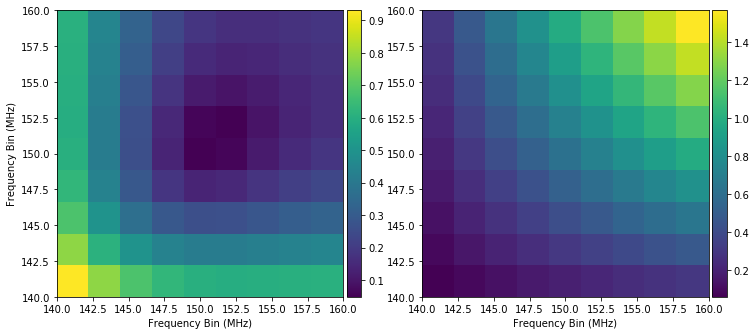

In [97]:
print(visibility_realisations.shape)
numerical_covariance = numpy.cov(visibility_realisations)

if calculate_covariance:
    %matplotlib inline
    figure = pyplot.figure(figsize = (12,6))
    a_covariance_plot = figure.add_subplot(121)
    analytic_plot = a_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(analytic_covariance))
    a_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    a_covariance_plot.set_ylabel('Frequency Bin (MHz)')
    a_covariance_plot.set_aspect('equal')
    a_covariance_plot.set_title("Fully Analytic")


    n_covariance_plot = figure.add_subplot(122)
    numerical_plot = n_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(numerical_covariance))
    n_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    n_covariance_plot.set_title("Fully Numerical MWA Style Beam")

    colorbar(analytic_plot)
    colorbar(numerical_plot)

    n_covariance_plot.set_aspect('equal')
    pyplot.show()

## The Semi-Numerical Covariance Calculation


In [23]:
from SkyModel import point_source_visibility

def semi_analytic_visibility_beam_covariance(xyz_positions, frequency_range, sky_param, sky_seed = 0,
                                             visibility_generate = "numerical", verbose = True):
    baseline_index = 0
    gain_table = antenna_gain_creator(xyz_positions, frequency_range)
    baseline_table = baseline_converter(xyz_positions, gain_table, frequency_range, verbose = False)
    baseline_selection = numpy.array([baseline_table[baseline_index]])

    if sky_param[0] == 'random':
        all_flux, all_l, all_m = flux_distribution(['random', sky_seed])
    elif sky_param[0] == 'point':
        all_flux, all_l, all_m = flux_distribution(['single', sky_param[1],
                                                    sky_param[2], sky_param[3]])
    point_source_list = numpy.stack((all_flux, all_l, all_m), axis=1)

    print("Iterating over 16 realisations of a perturbed Gaussian beam")
    if visibility_generate == "numerical":
        visibility_realisations = numerical_visibilities(
            point_source_list, baseline_selection, frequency_range, verbose)
    elif visibility_generate == "analytical":
        visibility_realisations = analytical_visibilities(
            point_source_list, baseline_selection, frequency_range, verbose)

    print("Calculating the covariance matrix for a single baseline over the frequency range")
    
    #visibility_covariance = numpy.cov(visibility_realisations)

    return visibility_realisations


def numerical_visibilities(point_source_list, baseline_table, frequency_range, verbose = True):
    visibility_realisations = numpy.zeros((frequency_range.shape[0], 16), dtype=complex)

    if verbose:
        print("Calculating Numerical visibilities for 16 gaussian beam maps")
    sky_cube, l_coordinates, m_coordinates = flux_list_to_sky_image(point_source_list, baseline_table)
    ll, mm, ff = numpy.meshgrid(l_coordinates, m_coordinates, frequency_range)
    
    wavelength = c/ff
    dipole_sep = 1.1  # meters
    x_offsets = numpy.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5, -1.5,
                             -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5], dtype=numpy.float32)*dipole_sep

    y_offsets = numpy.array([1.5, 1.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, -0.5, -0.5,
                             -0.5, -0.5, -1.5, -1.5, -1.5, -1.5], dtype=numpy.float32)*dipole_sep
    z_offsets = numpy.zeros(x_offsets.shape)
    
    
    beamwidth = beam_width(ff)
    ideal_beam = numpy.exp(-(ll**2. + mm**2.)/(2.*beamwidth**2))
    for faulty_dipole in range(16):
        perturbed_beam = (1 - 1/16*numpy.exp(-2.*numpy.pi*1j*(x_offsets[faulty_dipole]*ll + 
                                                     y_offsets[faulty_dipole]*mm)/wavelength))*ideal_beam
        
        for frequency_index in range(len(frequency_range)):
            visibility_realisations[frequency_index, faulty_dipole] = visibility_extractor(
                baseline_table[:, :, frequency_index], sky_cube[:, :, frequency_index],
                ideal_beam[:, :, frequency_index], perturbed_beam[:, :, frequency_index])
    
    return visibility_realisations


def analytical_visibilities(point_source_list, baseline_table, frequency_range, verbose = True):
    visibility_realisations = numpy.zeros((frequency_range.shape[0], 16), dtype=complex)
    dipole_sep = 1.1  # meters

    x_offsets = numpy.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5, -1.5,
                             -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5], dtype=numpy.float32)*dipole_sep

    y_offsets = numpy.array([1.5, 1.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, -0.5, -0.5,
                             -0.5, -0.5, -1.5, -1.5, -1.5, -1.5], dtype=numpy.float32)*dipole_sep
    z_offsets = numpy.zeros(x_offsets.shape)
    
    
    beamwidth = beam_width(frequency_range)
    if verbose:
        print("Calculating Analytical visibilities for 16 dipole beam realisation")
    for faulty_dipole in range(16):

        for frequency_index in range(len(frequency_range)):
            
            
            u = baseline_table[0,2,frequency_index]
            v = baseline_table[0,3,frequency_index]
            wavelength = c/frequency_range[frequency_index]
            
            flux = point_source_list[:,0]
            l = point_source_list[:,1]
            m = point_source_list[:,2]
            
            for i in range(len(flux)):
                point_source = flux[i]*numpy.exp(-2. * numpy.pi * 1j * (u * l[i] + v * m[i]))
                attenuation = numpy.exp(-0.5 * (l[i] ** 2. + m[i] ** 2.) / beamwidth[frequency_index] ** 2.)
                phase_factor= (1 - 1/16*numpy.exp(-2*numpy.pi*1j*(x_offsets[faulty_dipole]*l[i] + 
                                                     y_offsets[faulty_dipole]*m[i])/wavelength))
                
                visibility_realisations[frequency_index, faulty_dipole] += point_source*attenuation**2.*phase_factor
    
    return visibility_realisations



In [99]:
semi_analytic = semi_analytic_visibility_beam_covariance(xyz_positions, frequency_range, sky_param, sky_seed = 0,
                                             visibility_generate = "analytical")
semi_numerical = semi_analytic_visibility_beam_covariance(xyz_positions, frequency_range, sky_param, sky_seed = 0,
                                             visibility_generate = "numerical")




Converting xyz to uvw-coordinates

Number of antenna = 2
Total number of baselines = 1
Iterating over 16 realisations of a perturbed Gaussian beam
Calculating Analytical visibilities for 16 dipole beam realisation
Calculating the covariance matrix for a single baseline over the frequency range

Converting xyz to uvw-coordinates

Number of antenna = 2
Total number of baselines = 1
Iterating over 16 realisations of a perturbed Gaussian beam
Calculating Numerical visibilities for 16 gaussian beam maps
Calculating the covariance matrix for a single baseline over the frequency range


In [100]:
#cross_check =  analytic - numerical
#print(cross_check)

In [101]:
sa_covariance = numpy.cov(semi_analytic)
sn_covariance = numpy.cov(semi_numerical)
#print(a_covariance - n_covariance)

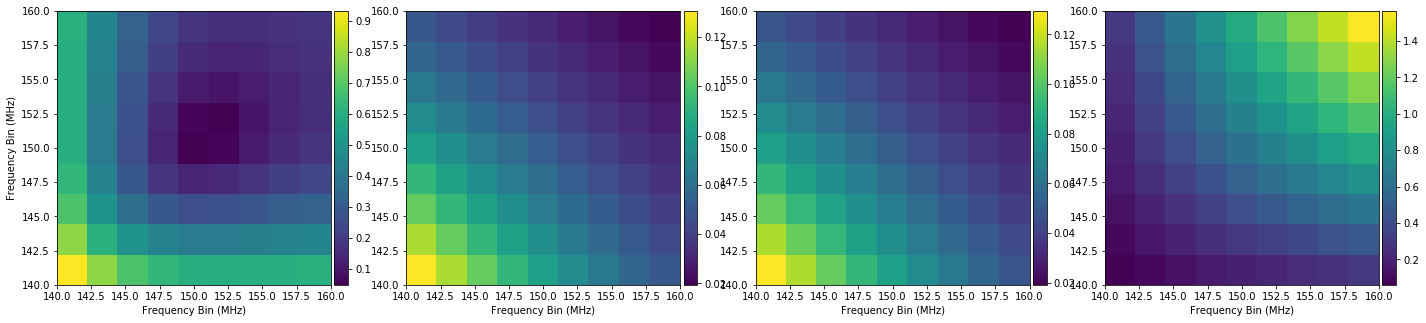

In [102]:
if calculate_covariance:
    %matplotlib inline
    figure = pyplot.figure(figsize = (27,6))
    
    a_covariance_plot = figure.add_subplot(141)
    a_plot = a_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(analytic_covariance))
    a_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    a_covariance_plot.set_ylabel('Frequency Bin (MHz)')
    a_covariance_plot.set_title("Fully Analytic")

    a_covariance_plot.set_aspect('equal')
    colorbar(a_plot)
    
    sa_covariance_plot = figure.add_subplot(142)
    sa_plot = sa_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(sa_covariance))
    sa_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    sa_covariance_plot.set_title("Semi Analytic Gaussian Style")
    sa_covariance_plot.set_aspect('equal')
    colorbar(sa_plot)

    sn_covariance_plot = figure.add_subplot(143)
    sn_plot = sn_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(sn_covariance))
    sn_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    sn_covariance_plot.set_title("Semi Numerical Gaussian Style")

    sn_covariance_plot.set_aspect('equal')
    colorbar(sn_plot)
    
    n_covariance_plot = figure.add_subplot(144)
    n_plot = n_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(numerical_covariance))
    n_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    n_covariance_plot.set_title("Numerical MWA Style")

    n_covariance_plot.set_aspect('equal')
    colorbar(n_plot)

    pyplot.show()

## Compare the different versions for different source elevations.

In [27]:
def covariance_comparison(sky_param, verbose = True):
    flux = numpy.array([sky_param[1]])
    frequency_0 = numpy.array([150e6])
    source_l = numpy.array([sky_param[2]])
    source_m = numpy.array([sky_param[3]])
    spectral_index = numpy.array([0.8])

    sky_model = PointSourceSky()
    sky_model.add_source(flux, frequency_0, source_l, source_m, spectral_index)
    
    frequency_range = numpy.linspace(140, 160, 10)*1e6
    
    dx = 20
    dy = 10

    ff1, ff2 = numpy.meshgrid(frequency_range, frequency_range)
    analytic_covariance = beam_covariance(dx, dy, ff1, ff2, sky_model)
    
    # create array
    noise_param = [False, 20e3, 40e3, 120]
    beam_param = ['gaussian', 0.25, 0.25]
    # telescope_param = ["hex", 14., 0, 0]
    telescope_param = ["linear", 10, 5, 0]
    sky_seed = 0

    xyz_positions = numpy.zeros((2,4))
    xyz_positions[0,0] = 1
    xyz_positions[1,0] = 2

    xyz_positions[1,1] = dx
    xyz_positions[1,2] = dy
    
    visibility_realisations = visibility_beam_covariance(xyz_positions, frequency_range, sky_param, load=False , verbose = verbose)
    numerical_covariance = numpy.cov(visibility_realisations)
    
    semi_analytic = semi_analytic_visibility_beam_covariance(xyz_positions, frequency_range, sky_param, sky_seed = 0,
                                             visibility_generate = "analytical", verbose = verbose)
    semi_numerical = semi_analytic_visibility_beam_covariance(xyz_positions, frequency_range, sky_param, sky_seed = 0,
                                             visibility_generate = "numerical", verbose = verbose)
    sa_covariance = numpy.cov(semi_analytic)
    sn_covariance = numpy.cov(semi_numerical)
    %matplotlib inline
    
    figure = pyplot.figure(figsize = (27,6))
    
    a_covariance_plot = figure.add_subplot(141)
    a_plot = a_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(analytic_covariance))
    a_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    a_covariance_plot.set_ylabel('Frequency Bin (MHz)')
    a_covariance_plot.set_title("Fully Analytic")

    a_covariance_plot.set_aspect('equal')
    colorbar(a_plot)
    
    sa_covariance_plot = figure.add_subplot(142)
    sa_plot = sa_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(sa_covariance))
    sa_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    sa_covariance_plot.set_title("Semi Analytic Gaussian Style")
    sa_covariance_plot.set_aspect('equal')
    colorbar(sa_plot)

    sn_covariance_plot = figure.add_subplot(143)
    sn_plot = sn_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(sn_covariance))
    sn_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    sn_covariance_plot.set_title("Semi Numerical Gaussian Style")

    sn_covariance_plot.set_aspect('equal')
    colorbar(sn_plot)
    
    n_covariance_plot = figure.add_subplot(144)
    n_plot = n_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(numerical_covariance))
    n_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    n_covariance_plot.set_title("Numerical MWA Style")

    n_covariance_plot.set_aspect('equal')
    colorbar(n_plot)

    pyplot.show()

/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:265: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:266: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:266: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


Iterating over 16 realisations of a perturbed Gaussian beam
Calculating the covariance matrix for a single baseline over the frequency range
Iterating over 16 realisations of a perturbed Gaussian beam
Calculating the covariance matrix for a single baseline over the frequency range


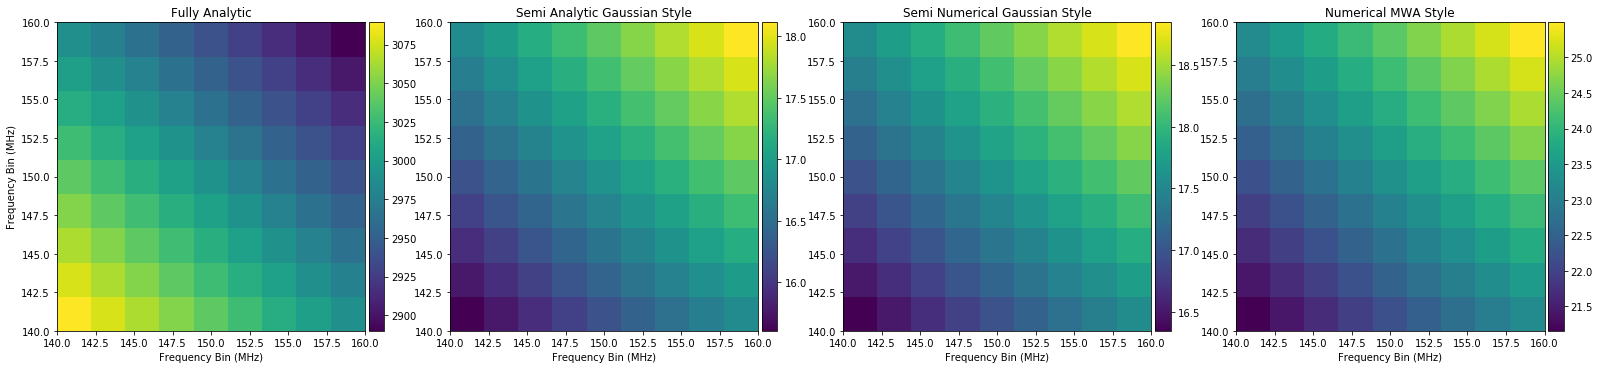

Iterating over 16 realisations of a perturbed Gaussian beam
Calculating the covariance matrix for a single baseline over the frequency range
Iterating over 16 realisations of a perturbed Gaussian beam
Calculating the covariance matrix for a single baseline over the frequency range


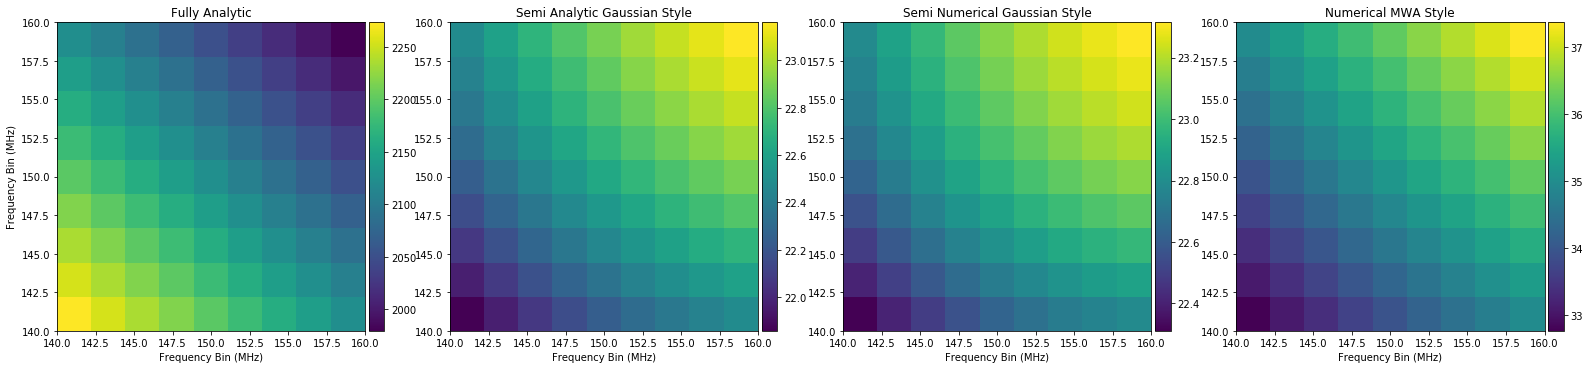

Iterating over 16 realisations of a perturbed Gaussian beam
Calculating the covariance matrix for a single baseline over the frequency range
Iterating over 16 realisations of a perturbed Gaussian beam
Calculating the covariance matrix for a single baseline over the frequency range


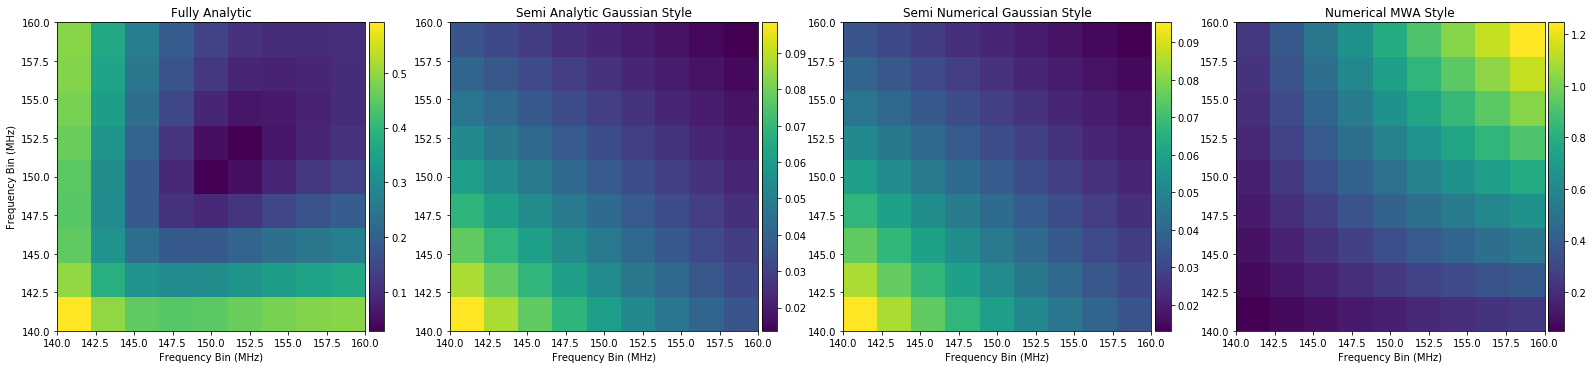

Iterating over 16 realisations of a perturbed Gaussian beam
Calculating the covariance matrix for a single baseline over the frequency range
Iterating over 16 realisations of a perturbed Gaussian beam
Calculating the covariance matrix for a single baseline over the frequency range


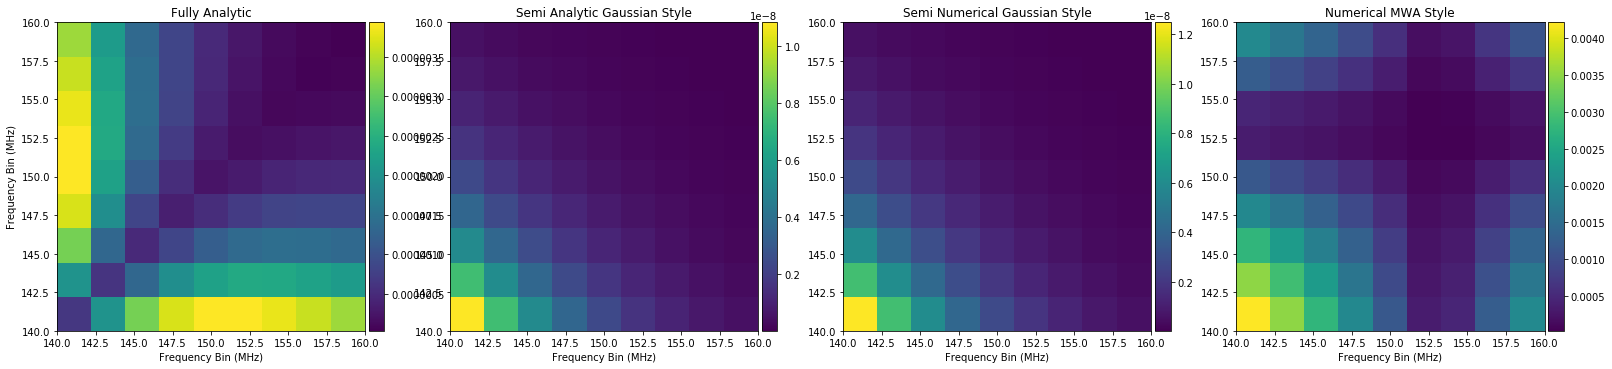

In [30]:
covariance_comparison(sky_param = ['point', 200, 0.01, 0.1], verbose = False)
covariance_comparison(sky_param = ['point', 200, 0.10, 0.1], verbose = False)
covariance_comparison(sky_param = ['point', 200, 0.50, 0.1], verbose = False)
covariance_comparison(sky_param = ['point', 200, 0.90, 0.1], verbose = False)


## Debugging the code

In [80]:
def visibility_extractor(baseline_table, sky_cube, antenna1_response, antenna2_response):
    apparent_sky = sky_cube*antenna1_response*numpy.conj(antenna2_response)
    padding_factor = 3
    
    padded_sky = numpy.pad(apparent_sky, padding_factor*len(apparent_sky), mode = "constant")
    shifted_image = numpy.fft.ifftshift(padded_sky,  axes=(0, 1))
    visibility_grid, uv_coordinates = powerbox.dft.fft(shifted_image, L=2*(2*padding_factor + 1),  axes=(0, 1))
    
    measured_visibilities = uv_list_to_baseline_measurements(baseline_table,visibility_grid, uv_coordinates)
    return measured_visibilities

In [81]:
def uv_list_to_baseline_measurements(baseline_table, visibility_grid, uv_grid):
    n_measurements = baseline_table.shape[0]
    
    u_bin_size = numpy.median(numpy.diff(uv_grid[0]))
    v_bin_size = numpy.median(numpy.diff(uv_grid[1]))
 

    #pyplot.pcolor(uv_grid[0], uv_grid[1], numpy.abs(visibility_grid))
    #pyplot.show()

    u_bin_centers = uv_grid[0] 
    v_bin_centers = uv_grid[1]
    
    
    #now we have the bin edges we can start binning our baseline table
    #Create an empty array to store our baseline measurements in
    visibility_data = visibility_grid
    
    real_component = interpolate.RegularGridInterpolator((u_bin_centers, v_bin_centers), numpy.real(visibility_data))
    imag_component = interpolate.RegularGridInterpolator((u_bin_centers, v_bin_centers), numpy.imag(visibility_data))
    visibilities = real_component(baseline_table[:, 2:4]) + \
                                           1j*imag_component(baseline_table[:, 2:4])
    
    #uu, vv = numpy.meshgrid(uv_grid[0], uv_grid[1])
    
    #real_component = interpolate.griddata((uu.flatten(), vv.flatten()), numpy.real(visibility_data.flatten()), (baseline_table[:, 2], baseline_table[:, 3]), method='cubic' )
    #imag_component = interpolate.griddata((uu.flatten(), vv.flatten()), numpy.imag(visibility_data.flatten()), (baseline_table[:, 2],  baseline_table[:, 3]), method='cubic')
    
    
    #visibilities = real_component + 1j*imag_component

    return visibilities

def uv_list_to_baseline_measurements_interp(baseline_table, visibility_grid, uv_grid):
    n_measurements = baseline_table.shape[0]
    
    u_bin_size = numpy.median(numpy.diff(uv_grid[0]))
    v_bin_size = numpy.median(numpy.diff(uv_grid[1]))
    
    u_bin_centers = uv_grid[0] - u_bin_size/2.
    v_bin_centers = uv_grid[1] - v_bin_size/2.
    
    #now we have the bin edges we can start binning our baseline table
    #Create an empty array to store our baseline measurements in
    visibility_data = visibility_grid
    
    real_component = interpolate.interp2d(u_bin_centers, v_bin_centers, numpy.real(visibility_data), kind ='quintic')
    imag_component = interpolate.interp2d(u_bin_centers, v_bin_centers, numpy.imag(visibility_data), kind ='quintic')

    visibilities = real_component(baseline_table[:, 2], baseline_table[:, 3]) + \
            1j*imag_component(baseline_table[:, 2], baseline_table[:, 3])
    
    return visibilities

In [82]:
# create array
sky_param = ['single', 200, 0.99, 0.]
noise_param = [False, 20e3, 40e3, 120]
beam_param = ['gaussian', 0.25, 0.25]
# telescope_param = ["hex", 14., 0, 0]
telescope_param = ["linear", 50, 5, 0]
sky_seed = 0

In [83]:
xyz_positions = xyz_position_creator(telescope_param)
gain_table = antenna_gain_creator(xyz_positions, frequency_range)
baseline_table = baseline_converter(xyz_positions, gain_table, frequency_range)

if sky_param[0] == 'random':
    all_flux, all_l, all_m = flux_distribution(['random', sky_seed])
elif sky_param[0] == 'single':
    all_flux, all_l, all_m = flux_distribution(sky_param)
point_source_list = numpy.stack((all_flux, all_l, all_m), axis=1)

baseline_index = 0
baseline_selection = numpy.array([baseline_table[baseline_index]])

sky_cube, l_coordinates, m_coordinates = flux_list_to_sky_image(point_source_list, baseline_selection)


Creating x- y- z-positions of a 5 element linear array

Converting xyz to uvw-coordinates

Number of antenna = 5
Total number of baselines = 10


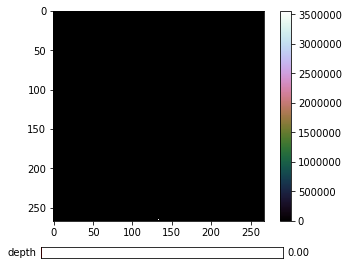

In [84]:
interactive_frequency_plotter(sky_cube)

In [85]:
ll, mm, ff = numpy.meshgrid(l_coordinates, m_coordinates, frequency_range)
tt, pp, = lm_to_theta_phi(ll, mm)

/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:265: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:266: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:266: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


#### This is very a realised I shouldn't pass along the frequency channels as pointing centers!

In [86]:
ideal_beam = mwa_tile_beam(tt, pp, frequency=ff)

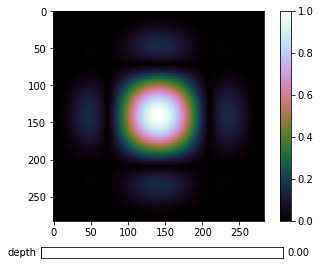

In [26]:
interactive_frequency_plotter(numpy.abs(ideal_beam))

### I now do the FFT and the baseline extraction at the frequency level, because it becomes to computationally heavy.

So for some reason I interpolated between the uv_grid edges, rather than the bin centers. (Laziness That has been fixed) The visibilities for a single point source now line up with  the numerical.


NOTE: fftfreq, the underlying function in powerbox that calculates the frequency bins actually gives the bin centers. So that should be fine.

We now investigate the difference in interpolators. 
- RegularGridInterpolator uses the regularness to speed up interpolation but has only linear options. Even after changing the interpolation from bin edges to bin centers, I see a phase delay. 
- Now trying interp2d as well with quintic interpolation

RegularGridInterpolator is the fastest and it's alright if we pad with enough zeros (3x image)

Also I wasted most likely lots of time trying to get my visibilities to allign perfectly (analytical and numerical). Most likely cause of phase difference? Pixelisation, which matters more when the source is further away from phase centre

In [119]:
t0 = time.time()
visibilities_grid = numpy.zeros(frequency_range.shape[0], dtype=complex)
for frequency_index in range(len(frequency_range)):
    visibilities_grid[frequency_index] = visibility_extractor(baseline_selection[:,:,frequency_index], 
                                                         sky_cube[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index])
t1 = time.time()
grid_time = t1-t0

t0 = time.time()
visibilities_interp = numpy.zeros(frequency_range.shape[0], dtype=complex)
for frequency_index in range(len(frequency_range)):
    visibilities_interp[frequency_index] = visibility_extractor(baseline_selection[:,:,frequency_index], 
                                                         sky_cube[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index], interpolate = "interp")
t1 = time.time()
interp_time = t1-t0

interp2 takes 3x as long as RegularGridInterpolator
griddata takes way longer than RegularGridInterpolator

In [120]:
l_index = numpy.where(numpy.min(numpy.abs(l_coordinates - sky_param[2])) == numpy.abs(l_coordinates - sky_param[2]))[0]
m_index = numpy.where(numpy.min(numpy.abs(m_coordinates - sky_param[3])) == numpy.abs(m_coordinates - sky_param[3]))[0]

beam_values = ideal_beam[l_index, m_index,:][0,:]
analytic = beam_values*numpy.conj(beam_values)*\
    sky_param[1]*numpy.exp(-2.*numpy.pi*1j*(baseline_selection[0,2]*sky_param[2] 
                                                   + baseline_selection[0,3]*sky_param[3]))

In [121]:
print(l_index)
print(m_index)
analytic_pixelised = beam_values*numpy.conj(beam_values)*\
    sky_param[1]*numpy.exp(-2.*numpy.pi*1j*(baseline_selection[0,2]*l_coordinates[l_index] 
                                                   + baseline_selection[0,3]*m_coordinates[m_index]))

[281]
[141]


It seems there's a misallignment/phase delay between the numerical and analytical visibilities. I remember this could be caused by the pixelisation. So let's calculate the analytical results at the pixelised location of the source instead...


So the phase errors seem worse to me then they really are, also I should be comparing apples with apples rather than confusing myself.

- pixelisation creates a small phase delay, see residuals plot below. What is the other source of delay? Gridding and interpolation? Anyway, we will assume this is now at the acceptable level. 

Case closed for now.

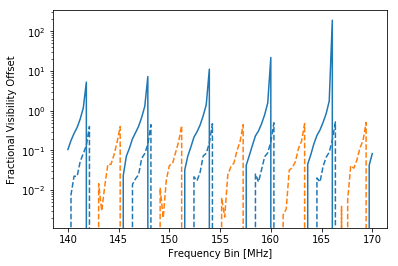

In [131]:
%matplotlib inline

pyplot.semilogy(frequency_range/1e6, (numpy.real(visibilities_grid) - numpy.real(analytic_pixelised))/numpy.real(analytic_pixelised),"C0")
pyplot.semilogy(frequency_range/1e6, (numpy.imag(visibilities_grid) - numpy.imag(analytic_pixelised)/numpy.imag(analytic_pixelised)),"C1")

pyplot.semilogy(frequency_range/1e6, (numpy.real(visibilities_grid) - numpy.real(analytic))/numpy.real(analytic),"C0--")
pyplot.semilogy(frequency_range/1e6, (numpy.imag(visibilities_grid) - numpy.imag(analytic))/numpy.imag(analytic),"C1--")

#pyplot.plot(frequency_range, numpy.real(visibilities_grid),"C0")
#pyplot.plot(frequency_range, numpy.imag(visibilities_grid),"C1")

#pyplot.plot(frequency_range, numpy.real(analytic), "C0--")
#pyplot.plot(frequency_range, numpy.imag(analytic), "C1--")

#pyplot.plot(frequency_range, numpy.real(analytic_pixelised), "C0+")
#pyplot.plot(frequency_range, numpy.imag(analytic_pixelised), "C1+")

pyplot.xlabel("Frequency Bin [MHz]")
pyplot.ylabel("Fractional Visibility Offset")



pyplot.show()

### Testing new faster dipole breaking code

In [135]:
def beam_rotator(first_fourth_dipole, first_third_dipole, second_third_dipole, faulty_dipole):
    if faulty_dipole == 0:
        dipole_beam = numpy.flip(first_fourth_dipole, axis=0)
    elif faulty_dipole == 1:
        dipole_beam = numpy.flip(first_third_dipole, axis=0)
    elif faulty_dipole == 2:
        dipole_beam = first_third_dipole
    elif faulty_dipole == 3:
        dipole_beam = first_fourth_dipole
    elif faulty_dipole == 4:
        dipole_beam = numpy.rot90(first_third_dipole, axes=(0, 1), k=-1)
    elif faulty_dipole == 5:
        dipole_beam = numpy.flip(second_third_dipole, axis=0)
    elif faulty_dipole == 6:
        dipole_beam = second_third_dipole
    elif faulty_dipole == 7:
        dipole_beam = numpy.flip(numpy.rot90(first_third_dipole, axes=(0, 1)), axis=1)
    elif faulty_dipole == 8:
        dipole_beam = numpy.flip(numpy.rot90(first_third_dipole, axes=(0, 1), k=3), axis=1)
    elif faulty_dipole == 9:
        dipole_beam = numpy.rot90(second_third_dipole, axes=(0, 1), k=2)
    elif faulty_dipole == 10:
        dipole_beam = numpy.rot90(second_third_dipole, axes=(0, 1), k=1)
    elif faulty_dipole == 11:
        dipole_beam = numpy.rot90(first_third_dipole, axes=(0, 1))
    elif faulty_dipole == 12:
        dipole_beam = numpy.rot90(first_fourth_dipole, k=2)
    elif faulty_dipole == 13:
        dipole_beam = numpy.rot90(first_third_dipole, k=2)
    elif faulty_dipole == 14:
        dipole_beam = numpy.flip(first_third_dipole, axis=1)
    elif faulty_dipole == 15:
        dipole_beam = numpy.flip(first_fourth_dipole, axis=1)
    
    return dipole_beam

In [168]:
def ideal_beam_perturber(ideal_beam, first_fourth_dipole, first_third_dipole, second_third_dipole, faulty_dipole):
    if faulty_dipole == 0:
        dipole_beam = numpy.flip(first_fourth_dipole, axis=0)
    elif faulty_dipole == 1:
        dipole_beam = numpy.flip(first_third_dipole, axis=0)
    elif faulty_dipole == 2:
        dipole_beam = first_third_dipole
    elif faulty_dipole == 3:
        dipole_beam = first_fourth_dipole
    elif faulty_dipole == 4:
        dipole_beam = numpy.rot90(first_third_dipole, axes=(0, 1), k=3)
    elif faulty_dipole == 5:
        dipole_beam = numpy.flip(second_third_dipole, axis=0)
    elif faulty_dipole == 6:
        dipole_beam = second_third_dipole
    elif faulty_dipole == 7:
        dipole_beam = numpy.flip(numpy.rot90(first_third_dipole, axes=(0, 1)), axis=1)
    elif faulty_dipole == 8:
        dipole_beam = numpy.flip(numpy.rot90(first_third_dipole, axes=(0, 1), k=3), axis=1)
    elif faulty_dipole == 9:
        dipole_beam = numpy.rot90(second_third_dipole, axes=(0, 1), k=2)
    elif faulty_dipole == 10:
        dipole_beam = numpy.rot90(second_third_dipole, axes=(0, 1), k=1)
    elif faulty_dipole == 11:
        dipole_beam = numpy.rot90(first_third_dipole, axes=(0, 1))
    elif faulty_dipole == 12:
        dipole_beam = numpy.rot90(first_fourth_dipole, k=2)
    elif faulty_dipole == 13:
        dipole_beam = numpy.rot90(first_third_dipole, k=2)
    elif faulty_dipole == 14:
        dipole_beam = numpy.flip(first_third_dipole, axis=1)
    elif faulty_dipole == 15:
        dipole_beam = numpy.flip(first_fourth_dipole, axis=1)
    
    perturbed_beam = ideal_beam - dipole_beam/16
    
    return perturbed_beam

#### Figure out which dipoles are the unique dipoles following Marcin's array ordering

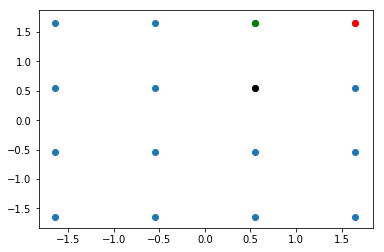

In [59]:
dipole_sep = 1.1  # meters
x_offsets = numpy.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5, -1.5,
                             -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5], dtype=numpy.float32) * dipole_sep

y_offsets = numpy.array([1.5, 1.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, -0.5, -0.5,
                             -0.5, -0.5, -1.5, -1.5, -1.5, -1.5], dtype=numpy.float32) * dipole_sep

first_fourth_index = 3 
first_third_index = 2
second_third_index = 6

pyplot.scatter(x_offsets, y_offsets)
pyplot.scatter(x_offsets[first_fourth_index], y_offsets[first_fourth_index], c="red")
pyplot.scatter(x_offsets[first_third_index], y_offsets[first_third_index], c="g")
pyplot.scatter(x_offsets[second_third_index], y_offsets[second_third_index], c="k")


pyplot.show()

In [149]:
#generate a grid of l and m
l = numpy.linspace(-1,1,100)
ll, mm = numpy.meshgrid(l,l)
tt, pp = lm_to_theta_phi(ll, mm)

ff = 150e6

#Calculate the full tile beam
ideal_beam = mwa_tile_beam(tt, pp, frequency=ff)

#Calculate the three unique beam perturbations
first_fourth_index = 3 
first_third_index = 2
second_third_index = 6

dipole_weights = numpy.zeros(16) 
dipole_weights[first_fourth_index] = 1
first_fourth_dipole = mwa_tile_beam(tt, pp, weights=dipole_weights, frequency=ff)

dipole_weights = numpy.zeros(16)
dipole_weights[first_third_index] = 1
first_third_dipole = mwa_tile_beam(tt, pp, weights=dipole_weights, frequency=ff)

dipole_weights = numpy.zeros(16) 
dipole_weights[second_third_index] = 1
second_third_dipole = mwa_tile_beam(tt, pp, weights=dipole_weights, frequency=ff)

/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:248: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))


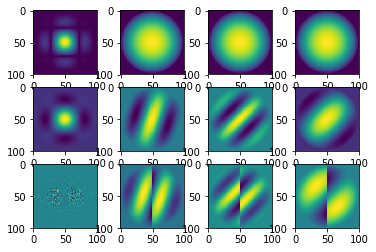

In [164]:
figure = pyplot.figure()
for counter in range(4):
    abs_ax = figure.add_subplot(3,4,1 + counter)
    real_ax= figure.add_subplot(3,4,5 + counter)
    imag_ax= figure.add_subplot(3,4,9 + counter)

    if counter == 0:
        beam = ideal_beam
    elif counter == 1:
        beam = first_third_dipole
    elif counter == 2:
        beam = first_fourth_dipole
    elif counter == 3:
        beam = second_third_dipole
    
    abs_ax.imshow(numpy.abs(beam))
    real_ax.imshow(numpy.real(beam))
    imag_ax.imshow(numpy.imag(beam))

pyplot.show()

### Check whether all the rotations are correct

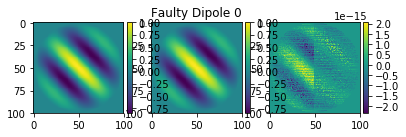

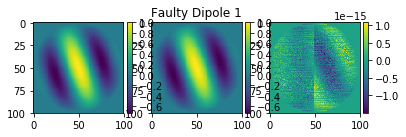

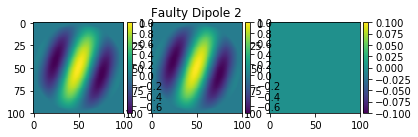

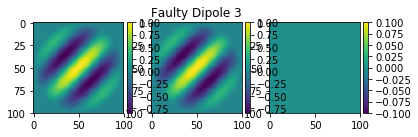

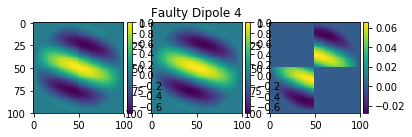

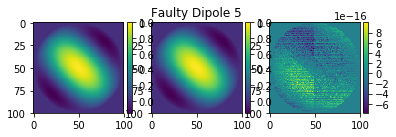

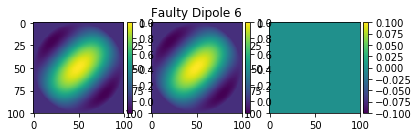

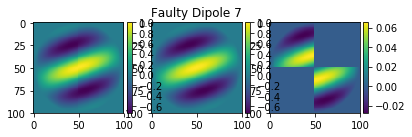

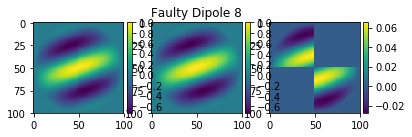

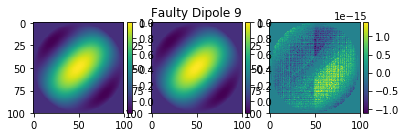

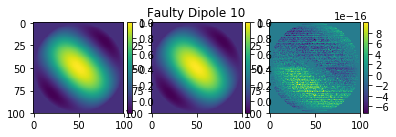

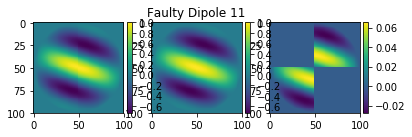

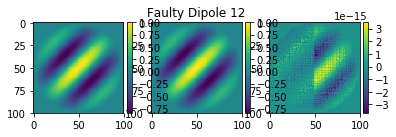

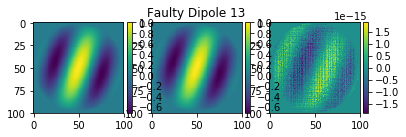

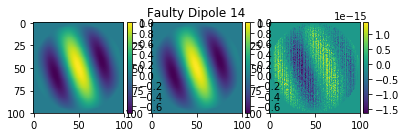

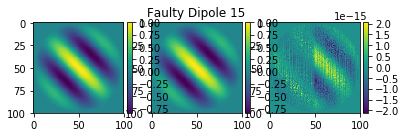

In [167]:
for faulty_dipole in range(16):
    dipole_weights = numpy.zeros(16) 
    dipole_weights[faulty_dipole] = 1
    dipole_beam = mwa_tile_beam(tt, pp, weights=dipole_weights, frequency=ff)
    
    rotated_beam = beam_rotator(first_fourth_dipole, first_third_dipole, 
                               second_third_dipole, faulty_dipole)
    
    figure = pyplot.figure()
    dipole_plot = figure.add_subplot(131)
    rotate_plot = figure.add_subplot(132)
    diff_plot = figure.add_subplot(133)
    
    dipole_color = dipole_plot.imshow(numpy.real(dipole_beam))
    rotate_color = rotate_plot.imshow(numpy.real(rotated_beam))
    diff_color = diff_plot.imshow(numpy.real(rotated_beam - dipole_beam))
    rotate_plot.set_title(f"Faulty Dipole {faulty_dipole}")
    
    colorbar(dipole_color)
    colorbar(rotate_color)
    colorbar(diff_color)
    



/home/ronniyjoseph/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/ronniyjoseph/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/ronniyjoseph/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/home/ronniyjoseph/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.

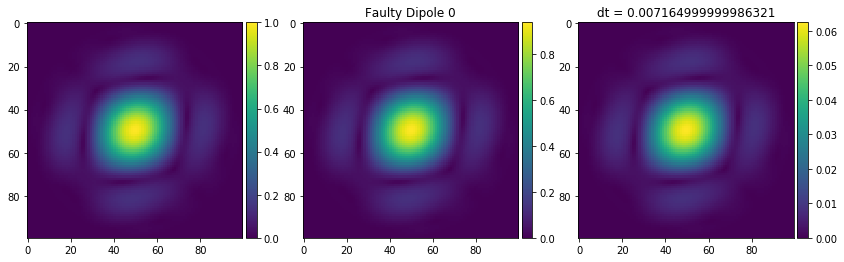

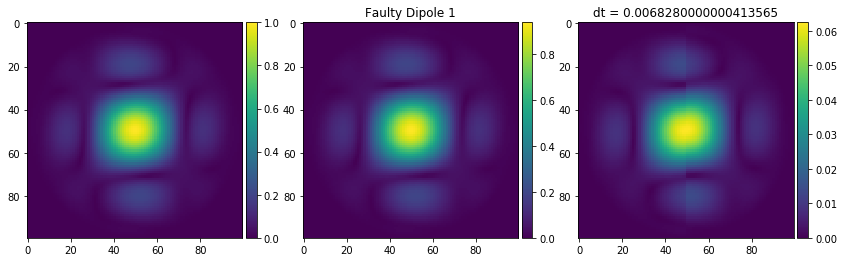

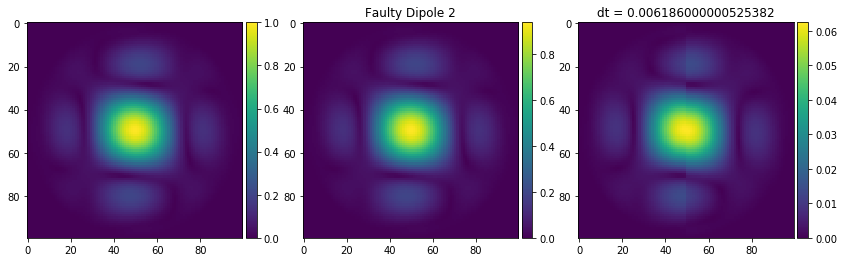

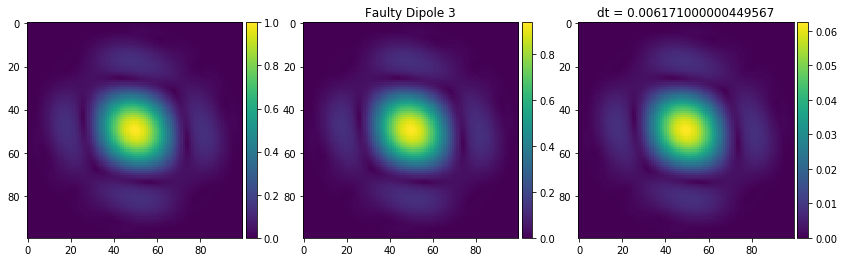

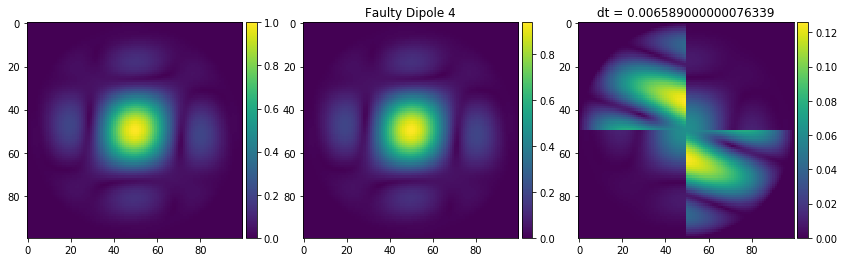

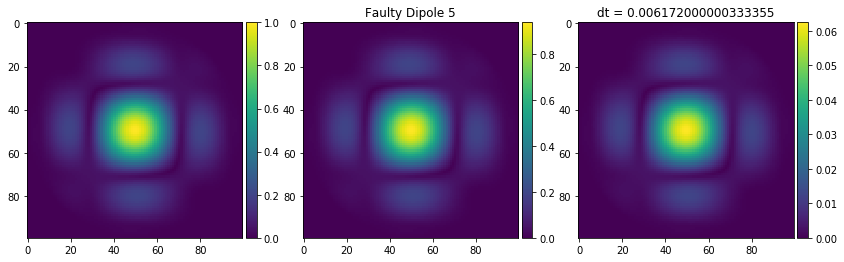

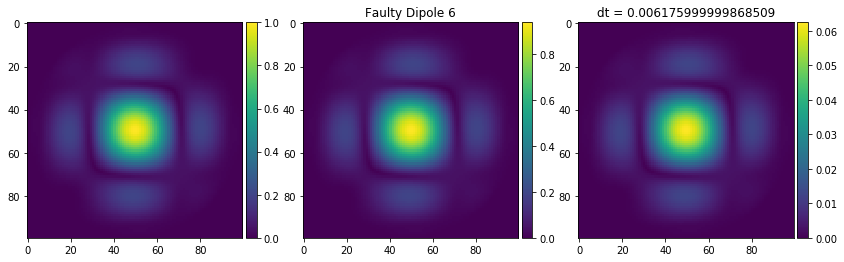

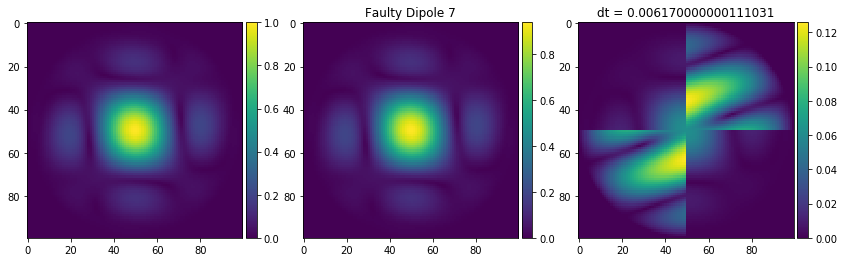

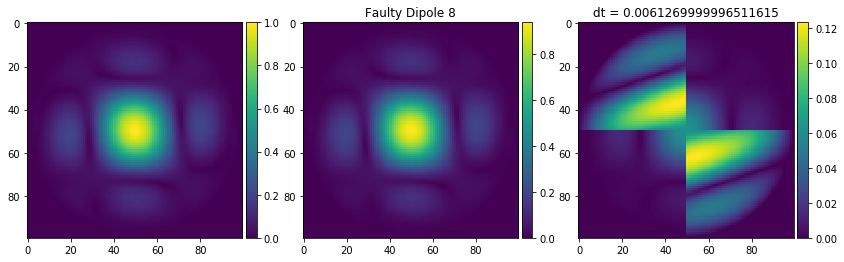

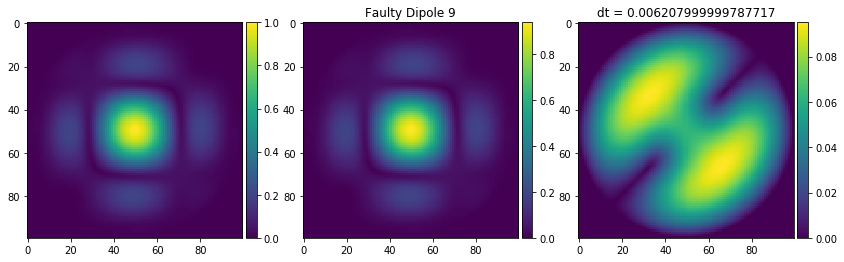

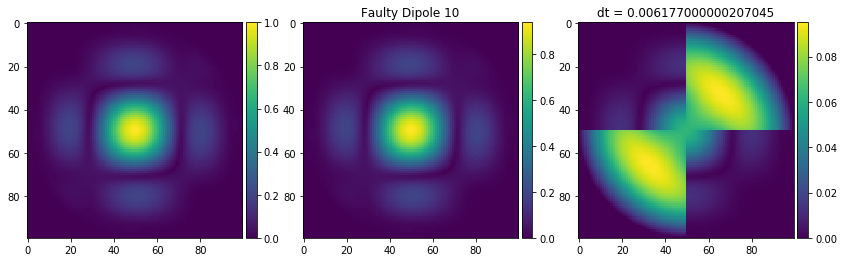

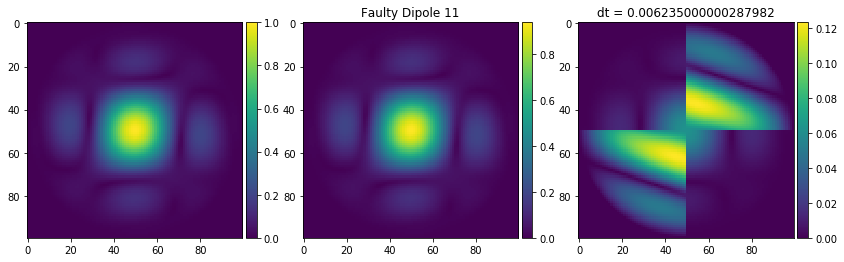

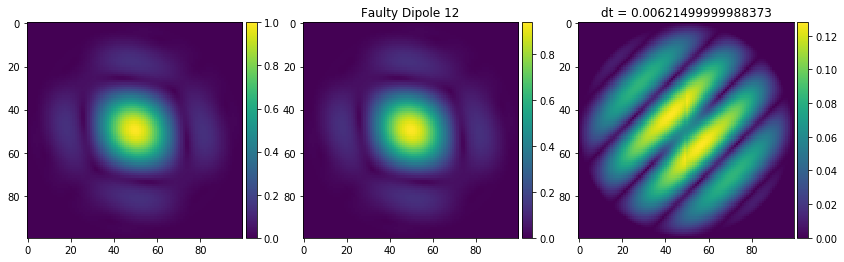

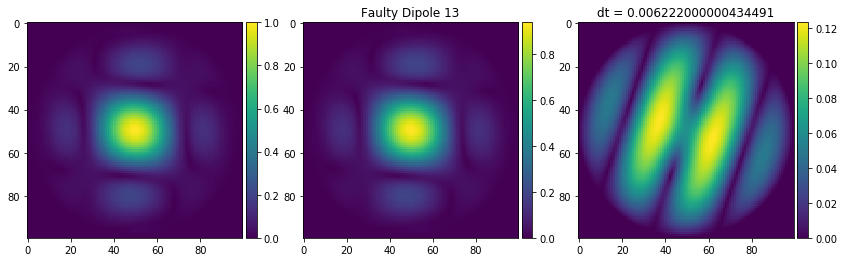

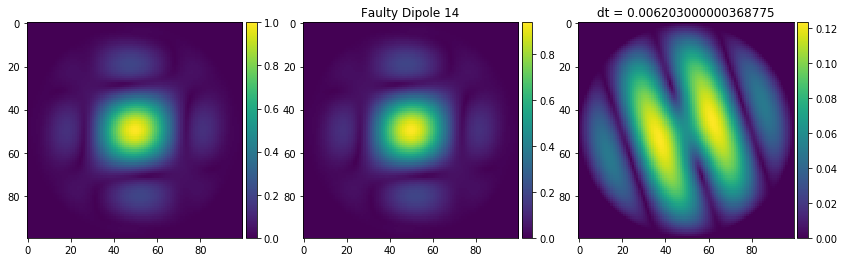

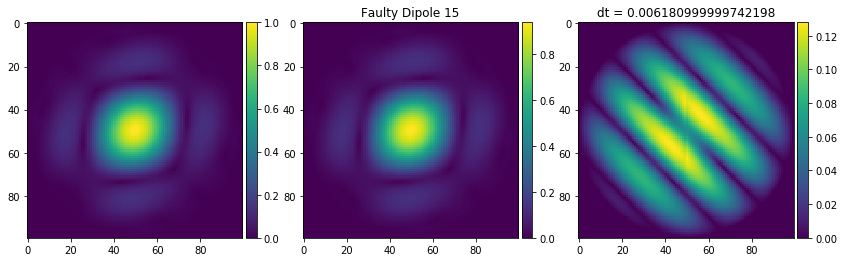

In [170]:
for faulty_dipole in range(16):
    
    dipole_weights = numpy.zeros(16) + 1
    dipole_weights[faulty_dipole] = 0
    
    t1 = time.clock()
    perturbed_beam = mwa_tile_beam(tt, pp, weights=dipole_weights, frequency=ff)
    t2 = time.clock()
    full_time = t2-t1
    
    t1 = time.clock()
    fast_perturbed_beam = ideal_beam_perturber(ideal_beam, first_fourth_dipole, first_third_dipole, 
                                                   second_second_dipole, faulty_dipole)
    t2 = time.clock()
    fast_time = t2 - t1
    
    
    
    figure = pyplot.figure(figsize=(14,4))
    full_plot = figure.add_subplot(131)
    fast_plot = figure.add_subplot(132)
    diff_plot = figure.add_subplot(133)
    
    full_color = full_plot.imshow(numpy.abs(perturbed_beam))
    fast_color = fast_plot.imshow(numpy.abs(fast_perturbed_beam))
    diff_color = diff_plot.imshow(numpy.abs(perturbed_beam - fast_perturbed_beam))
    
    fast_plot.set_title(f"Faulty Dipole {faulty_dipole}")
    diff_plot.set_title(f"dt = {full_time - fast_time}")
    
    colorbar(full_color)
    colorbar(fast_color)
    colorbar(diff_color)
